In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import plotly.graph_objects as go


from sklearn.cluster import KMeans # Our clustering algorithm
from sklearn.decomposition import PCA # Needed for dimension reduction
from sklearn.preprocessing import StandardScaler
from plotly.offline import iplot
from pygal_maps_world.maps import World #Importing world map 

In this section, we are going to cluster the countries based on its charecteristics. There are varying reasons for using a dimensionality reduction step such as PCA prior to data segmentation. By reducing the number of features, we’re improving the performance of our algorithm. On top of that, by decreasing the number of features the noise is also reduced.

In [4]:
#Import the dataset
df = pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/ultimate+aquastat+(flat).csv')  
df_GDP = pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/GDP.csv')

In [5]:
table=pd.pivot_table(data=df,values='Value',index=['Area','Year'],columns='Variable Name')
# drop undernourishment and add GDP  
table = table.drop('Prevalence of undernourishment (3-year average)', axis=1)  # TODO download correct data from AQUASTAT instead of dropping here
table_GDP = pd.pivot_table(data=df_GDP,values='Value',index=['Area','Year'],columns='Variable Name')
table
table = table.merge(table_GDP, how='inner', on=['Area','Year'])
table.head(21)

Variable Name       Agricultural water withdrawal as % of total renewable water resources  \
Area        Year                                                                            
Afghanistan 1992.0                                          35.498101                       
            1997.0                                          31.427856                       
            2002.0                                          30.613807                       
            2007.0                                          30.613807                       
            2012.0                                          30.613807                       
            2017.0                                          30.613807                       
            2018.0                                          30.613807                       
Argentina   1992.0                                                NaN                       
            1997.0                                           2.455948                       
            2002.0                                           2.588954                       
            2007.0                                           2.921470                       
            2012.0                                           3.187483                       
            2017.0                                           3.187483                       
            2018.0                                           3.187483                       
Australia   1992.0                                                NaN                       
            1997.0                                           3.131301                       
            2002.0                                           2.913110                       
            2007.0                                           1.987195                       
            2012.0                                           1.948577                       
            2017.0                                           2.250000                       
            2018.0                                           2.444073                       

Variable Name       Agriculture, value added (% GDP)  Average Temperature  \
Area        Year                                                            
Afghanistan 1992.0                         54.207106                12.61   
            1997.0                         62.416768                12.86   
            2002.0                         45.134344                13.91   
            2007.0                         35.265942                13.80   
            2012.0                         28.556142                13.25   
            2017.0                         25.574670                13.12   
            2018.0                         22.440899                14.55   
Argentina   1992.0                          5.193747                14.37   
            1997.0                          4.527197                15.14   
            2002.0                          8.848660                14.60   
            2007.0                          7.452354                14.20   
            2012.0                          5.781744                15.20   
            2017.0                          5.478382                15.30   
            2018.0                          6.097129                14.99   
Australia   1992.0                          3.263718                21.75   
            1997.0                          3.038954                21.82   
            2002.0                          2.888534                22.25   
            2007.0                          2.338630                22.08   
            2012.0                          2.278906                21.83   
            2017.0                          2.458346                22.57   
            2018.0                          2.121597                22.58   

Variable Name       Environmental Flow Requirements  GDP per capita  \
Area        Year 

In [6]:
table_preprocessed = table.fillna(method='bfill')
table_preprocessed.head(21)

Variable Name       Agricultural water withdrawal as % of total renewable water resources  \
Area        Year                                                                            
Afghanistan 1992.0                                          35.498101                       
            1997.0                                          31.427856                       
            2002.0                                          30.613807                       
            2007.0                                          30.613807                       
            2012.0                                          30.613807                       
            2017.0                                          30.613807                       
            2018.0                                          30.613807                       
Argentina   1992.0                                           2.455948                       
            1997.0                                           2.455948                       
            2002.0                                           2.588954                       
            2007.0                                           2.921470                       
            2012.0                                           3.187483                       
            2017.0                                           3.187483                       
            2018.0                                           3.187483                       
Australia   1992.0                                           3.131301                       
            1997.0                                           3.131301                       
            2002.0                                           2.913110                       
            2007.0                                           1.987195                       
            2012.0                                           1.948577                       
            2017.0                                           2.250000                       
            2018.0                                           2.444073                       

Variable Name       Agriculture, value added (% GDP)  Average Temperature  \
Area        Year                                                            
Afghanistan 1992.0                         54.207106                12.61   
            1997.0                         62.416768                12.86   
            2002.0                         45.134344                13.91   
            2007.0                         35.265942                13.80   
            2012.0                         28.556142                13.25   
            2017.0                         25.574670                13.12   
            2018.0                         22.440899                14.55   
Argentina   1992.0                          5.193747                14.37   
            1997.0                          4.527197                15.14   
            2002.0                          8.848660                14.60   
            2007.0                          7.452354                14.20   
            2012.0                          5.781744                15.20   
            2017.0                          5.478382                15.30   
            2018.0                          6.097129                14.99   
Australia   1992.0                          3.263718                21.75   
            1997.0                          3.038954                21.82   
            2002.0                          2.888534                22.25   
            2007.0                          2.338630                22.08   
            2012.0                          2.278906                21.83   
            2017.0                          2.458346                22.57   
            2018.0                          2.121597                22.58   

Variable Name       Environmental Flow Requirements  GDP per capita  \
Area        Year 

In [7]:
data=table_preprocessed.copy()
#data['% of total country area irrigated (%)']=data['% of total country area cultivated']*data['% of cultivated land irrigated [harvested crop]']/100
data['Industry, value added (% GDP)']=data['Industry, value added to GDP']/data['Gross Domestic Product (GDP)']*100
data['Services, value added (% GDP)']=data['Services, value added to GDP']/data['Gross Domestic Product (GDP)']*100

# PCA

In [8]:
#Standardize the data
df_pca=data.copy()
scaler = StandardScaler()
df_std=scaler.fit_transform(df_pca)

First, we fit our standardized data using PCA.

In [9]:
#Fit the data using PCA
pca=PCA()
pca.fit(df_std)

PCA()

Second, we need to decide how many features we’d like to keep based on the cumulative variance plot.


In [10]:
#The attribute shows how much variance is explained by each components
pca.explained_variance_ratio_

array([2.60415740e-01, 1.70573509e-01, 1.45677698e-01, 7.48325929e-02,
       6.54186348e-02, 5.96638560e-02, 5.22745257e-02, 4.16141484e-02,
       3.18735688e-02, 2.43663350e-02, 1.79554372e-02, 1.59925252e-02,
       1.05066634e-02, 9.76918528e-03, 6.23125337e-03, 4.38130565e-03,
       2.90393733e-03, 2.86360947e-03, 1.44767342e-03, 9.52289813e-04,
       2.67154718e-04, 1.83578551e-05])

Text(0, 0.5, 'Comulative Explained Variance')

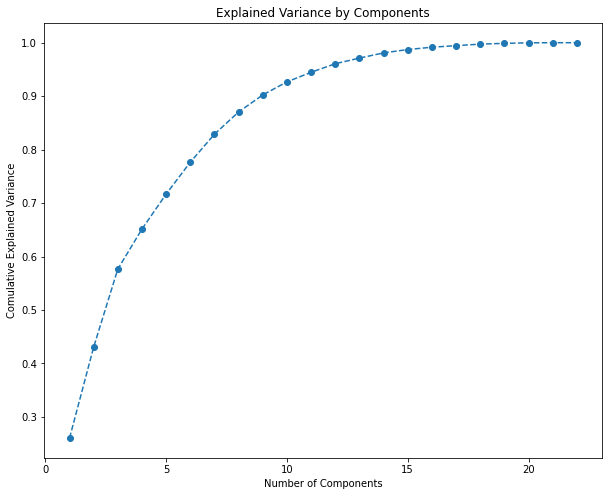

In [11]:
plt.figure(figsize=(10,8))
plt.plot(range(1,23),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Comulative Explained Variance')

As a third step, we perform PCA with the chosen number of components.

In [12]:
#We choose 5 components according to the previous graph.
pca=PCA(n_components=5)
#Fit the model the our data with selected number of components.
pca.fit(df_std)

PCA(n_components=5)

We need only the calculated resulting components scores for the elements in our data set:

In [13]:
pca.transform(df_std)
scores_pca=pca.transform(df_std)

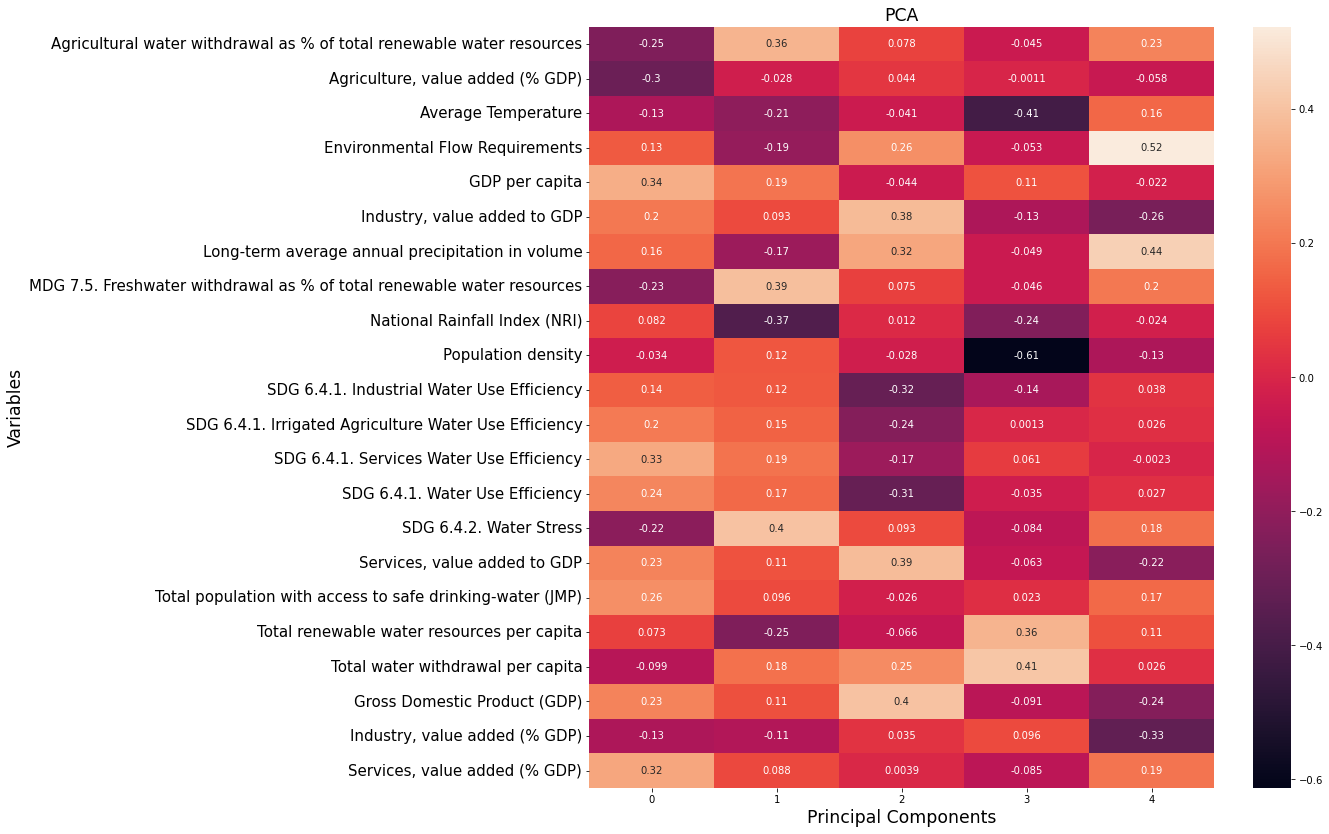

In [14]:
pcaloadings=pd.DataFrame(pca.components_)
pcaloadings.columns=df_pca.columns
pcaloadings=pcaloadings.T
plt.figure(figsize = (14,14))
ax = sns.heatmap(pcaloadings, annot=True)
ax.yaxis.set_tick_params(labelsize=15)
plt.title('PCA', fontsize='xx-large')
plt.ylabel('Variables', fontsize='xx-large')
plt.xlabel('Principal Components', fontsize='xx-large')
plt.savefig('PCA.png', dpi=500)

PC1 is more positively correlated with water use efficiency and GDP,PC2 has strong positive loadings on water stress and water withdrawl. PC3 highly correlated with GDP, while the PC4 has strong negative loadings on temperature and population density. PC5 is strongly correalated with the precipitation and environmental flow requirement.We can conclude that the water situation of these countries has following important features: GDP,water stress, population density,temperature,precipitation and water withdrawl.


We’ll incorporate the newly obtained PCA scores in the K-means algorithm. 

# Clustering

we run the algorithm with a different number of clusters. Then, we determine the Within Cluster Sum of Squares or WCSS for each solution. Based on the values of the WCSS and an approach known as the Elbow method, we make a decision about how many clusters we’d like to keep.

In [15]:
#We fit the k means using the transformed data from PCA
wcss=[]
for i in range(1,7):
 kmeans_pca=KMeans(n_clusters=i,init='k-means++',random_state=42)
 kmeans_pca.fit(scores_pca)
 wcss.append(kmeans_pca.inertia_)

The next step involves plotting the WCSS against the number of components on a graph.

Text(0, 0.5, 'wcss')

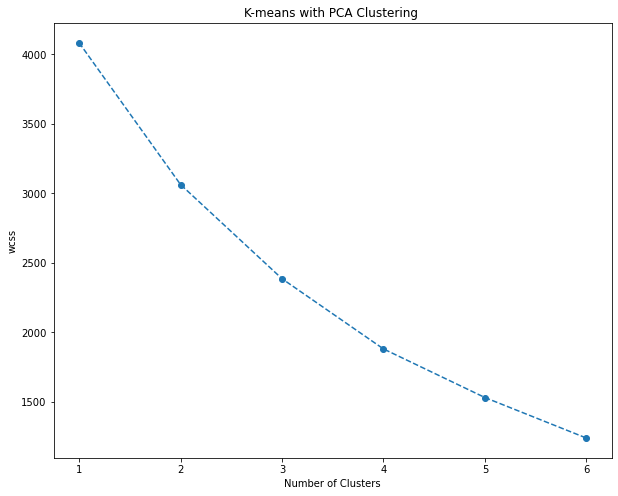

In [16]:
plt.figure(figsize=(10,8))
plt.plot(range(1,7),wcss,marker='o',linestyle='--')
plt.title('K-means with PCA Clustering ')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')

And from this graph, we determine the number of clusters we’d like to keep. To that effect, we use the Elbow-method. The approach consists of looking for a kink or elbow in the WCSS graph. Usually, the part of the graph before the elbow would be steeply declining, while the part after it – much smoother. In this instance, the kink comes at the third clusters mark. So, we’ll be keeping a three-cluster solution.

In [17]:
#We have 3 clusters, and same initrializer and random state as before.
kmeans_pca=KMeans(n_clusters=3,init='k-means++',random_state=21,n_init =50)
#We fit our data with the k-means model.
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=3, n_init=50, random_state=21)

K-Means Clustering with PCA results

In [18]:
#We create a new data frame with original features and PCA scores and assigned clusters.
df_pca_kmeans=pd.concat([df_pca.reset_index(),pd.DataFrame(scores_pca)],axis=1)
df_pca_kmeans.columns.values[-5:]=['PC1','PC2','PC3','PC4','PC5']
#The last columns we add contains the pca clustering labels.
df_pca_kmeans['Cluster']=kmeans_pca.labels_
df_pca_kmeans.set_index(['Area', 'Year'], inplace=True)
df_pca_kmeans.head()

Agricultural water withdrawal as % of total renewable water resources  \
Area        Year                                                                            
Afghanistan 1992.0                                          35.498101                       
            1997.0                                          31.427856                       
            2002.0                                          30.613807                       
            2007.0                                          30.613807                       
            2012.0                                          30.613807                       

                    Agriculture, value added (% GDP)  Average Temperature  \
Area        Year                                                            
Afghanistan 1992.0                         54.207106                12.61   
            1997.0                         62.416768                12.86   
            2002.0                         45.134344                13.91   
            2007.0                         35.265942                13.80   
            2012.0                         28.556142                13.25   

                    Environmental Flow Requirements  GDP per capita  \
Area        Year                                                      
Afghanistan 1992.0                            28.29      248.518890   
            1997.0                            28.29      164.092893   
            2002.0                            28.29      194.958382   
            2007.0                            28.29      389.985586   
            2012.0                            28.29      694.885618   

                    Industry, value added to GDP  \
Area        Year                                   
Afghanistan 1992.0                  5.530000e+08   
            1997.0                  4.220000e+08   
            2002.0                  9.150000e+08   
            2007.0                  2.600000e+09   
            2012.0                  4.360000e+09   

                    Long-term average annual precipitation in volume  \
Area        Year                                                       
Afghanistan 1992.0                                         213.48522   
            1997.0                                         213.48522   
            2002.0                                         213.48522   
            2007.0                                         213.48522   
            2012.0                                         213.48522   

                    MDG 7.5. Freshwater withdrawal as % of total renewable water resources  \
Area        Year                                                                             
Afghanistan 1992.0                                          35.910480                        
            1997.0                                          31.852952                        
            2002.0                                          31.045461                        
            2007.0                                          31.045461                        
            2012.0                                          31.045461                        

                    National Rainfall Index (NRI)  Population density  ...  \
Area        Year                                                       ...   
Afghanistan 1992.0                         304.98           22.187829  ...   
            1997.0                         233.00           29.649735  ...   
            2002.0                         185.00           34.618096  ...   
            2007.0                         185.00           41.510486  ...   
            2012.0                         185.00           47.730564  ...   

                    Total water withdrawal per capita  \
Area        Year                                        
Afghanistan 1992.0                        1619.567311   
            1997.0                        1075.032191   
            2002.0        

Visualize clusters by components

In [19]:
cluster0 = df_pca_kmeans[df_pca_kmeans["Cluster"] == 0]
cluster1 = df_pca_kmeans[df_pca_kmeans["Cluster"] == 1]
cluster2 = df_pca_kmeans[df_pca_kmeans["Cluster"] == 2]

In [20]:
#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["PC1"],
                    y = cluster0["PC2"],
                    z = cluster0["PC3"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["PC1"],
                    y = cluster1["PC2"],
                    z = cluster1["PC3"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)
#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["PC1"],
                    y = cluster2["PC2"],
                    z = cluster2["PC3"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Three Dimensions Using PCA"
layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

We can see the distribution of clusters on the first three components.
And there is some overlap between the cluster 0 and cluster 2, the spots where the two overlap maybe ultimately determined by the forth and fifth component, which is not available on this graph.

In [21]:
#Cluster in different year
df_cluster=df_pca_kmeans.loc[:,['Cluster']]
df_cluster=df_cluster.unstack('Year')
df_cluster


Cluster                              \
Year                                   1992.0 1997.0 2002.0 2007.0 2012.0   
Area                                                                        
Afghanistan                                 2      2      2      2      2   
Argentina                                   0      0      0      0      0   
Australia                                   0      1      0      1      1   
Azerbaijan                                  2      2      2      2      2   
Bolivia (Plurinational State of)            0      0      0      0      0   
Brazil                                      0      0      0      0      0   
Canada                                      1      1      1      1      1   
Central African Republic                    0      0      0      0      0   
China                                       0      0      0      0      1   
Democratic People's Republic of Korea       0      0      0      0      0   
Denmark                                     1      1      1      1      1   
El Salvador                                 0      0      0      0      0   
Finland                                     1      1      1      1      1   
France                                      1      1      1      1      1   
Gabon                                       0      0      0      0      0   
Haiti                                       0      0      0      0      0   
India                                       0      0      0      0      0   
Indonesia                                   0      0      0      0      0   
Iraq                                        2      2      2      2      2   
Israel                                      2      2      2      1      1   
Italy                                       1      1      1      1      1   
Japan                                       1      1      1      1      1   
Malaysia                                    0      0      0      0      0   
Mexico                                      0      0      0      0      0   
Morocco                                     2      2      2      2      2   
New Zealand                                 0      1      1      1      1   
Pakistan                                    2      2      2      2      2   
Poland                                      0      0      0      0      0   
South Africa                                0      0      0      0      0   
Suriname                                    0      0      0      0      0   
Tajikistan                                  2      2      2      2      2   
Tunisia                                     2      2      2      2      2   
Ukraine                                     0      0      0      0      0   
United States of America                    1      1      1      1      1   
Uzbekistan                                  2      2      2      2      2   
Viet Nam                                    0      0      0      0      0   
Zimbabwe                                    0      0      0      0      0   

                                                     
Year                                  2017.0 2018.0  
Area                                                 
Afghanistan                                2      2  
Argentina                                  0      0  
Australia                                  1      1  
Azerbaijan                                 2      2  
Bolivia (Plurinational State of)           0      0  
Brazil                                     0      0  
Canada                                     1      1  
Central African Republic                   0      0  
China                                      1      1  
Democratic People's Republic of Korea      0      0  
Denmark                                    1      1  
El Salvador                                0      0  
Finland                                    1      1  
France                                     1      1  
Gabon                                  

Most of the countries in the same class over the years. But some countries changed.

View the cluster of 2018 on the  world map

In [22]:
# creating object
worldmap_chart = World()
# adding title
worldmap_chart.title = 'Result of Cluster in 2018'
# add data
worldmap_chart.add('Cluster 0', ['ar', 'bo', 'br', 'cf','sv','ga','ht','in','id', 'ma','mx','za','sr''vn','zw'])
worldmap_chart.add('Cluster 1', ['au', 'ca', 'dk','cn', 'fi', 'fr', 'il', 'it', 'jp', 'nz', 'pl','us'])
worldmap_chart.add('Cluster 2', ['af','az','cf','kr','ir','ma','tn','tj','ua','uz','pa'])
# rendering the svg to file
worldmap_chart.render_to_file('cluster.svg')
